In [0]:
link = 'http://proc.lorett.org/data/Xkaliningrad/AQUA/2020-03/20200329_112358_AQUA_MOD021KM.hdf'  # вставить сслыку на нужный снимок сюда
reciever = 'Калининград'
name = link.split('/')[-1].split('.')[0]  # получаем название снимка без разрешения из ссылки

In [0]:
# Координаты и часовые пояса приёмных станций
coord_rec = {'Москва': (55.7108, 37.5263, 3), 'Калининград': (54.7067, 20.4991, 2), 'Сургут': (61.2422, 73.4006, 5)}

In [0]:
from google.colab import drive  # почему я каждый раз должен авторизовываться?((
drive.mount('/content/drive')

In [0]:
cd = '/content/drive/My Drive/AKS/'  # путь, куда сохраняем снимки и результаты

In [0]:
# скачиваем снимок онлайн бесплатно без регистрации и смс
from requests import get

img = get(link).content
open(cd + name + '.hdf', 'wb').write(img)

69442261

In [0]:
# импортирем библиотеки, gdal только для экспорта в GTiff
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# устанавливаем pyhdf и всякое к нему
!apt-get install build-essential python3-dev python3-numpy libhdf4-dev -y
!pip install pyhdf
from pyhdf.SD import SD, SDC

In [0]:
file = SD(cd + name + '.hdf', SDC.READ)

In [0]:
# загружаем координаты каждого 5 пикселя из hdf
latit = file.select('Latitude').get()
longit = file.select('Longitude').get()
latit.shape

(82, 271)

In [0]:
# получаем данные из 31 канала
longwave_bands = file.select('Band_1KM_Emissive')
longwave_data = file.select('EV_1KM_Emissive')

B31_index = list(longwave_bands.get()).index(31.)
B31_data = longwave_data.get()[B31_index]

B31_data.shape

(410, 1354)

In [0]:
# растягиваем матрицы с координатами на весь снимок
from scipy.ndimage.interpolation import zoom

lat = zoom(input=latit, zoom=5, order=0)[:, :-1]
lon = zoom(input=longit, zoom=5, order=0)[:, :-1]

In [0]:
# пересчитываем 31 канал в radiance
B31_L = longwave_data.attributes()['radiance_scales'][B31_index] * (B31_data - longwave_data.attributes()['radiance_offsets'][B31_index])

In [0]:
# пересчитываем radiance в температуру в кельвинах
c1 = 1.19104282e+8
c2 = 1.438775e+4
leng = 11.03
B31_T = (c2 / leng) / np.log(1 + c1 * leng ** -5 / B31_L)

In [0]:
# "обрезаем" снимок по региону интереса, заполняя ненужные пиксели значением NaN
deg = 111.13486
B31_roi = np.where(np.degrees(np.arccos(np.sin(np.radians(lat)) * \
                                      np.sin(np.radians(coord_rec[reciever][0])) + np.cos(np.radians(lat)) * \
                                      np.cos(np.radians(coord_rec[reciever][0])) * \
                                      np.cos(np.radians(lon) - np.radians(coord_rec[reciever][1])))) * deg > 100, np.nan, B31_T)
# B31_roi = np.where(np.sqrt((lat - coord_rec[reciever][0]) ** 2 + np.sqrt((lon - coord_rec[reciever][1]) ** 2)) * deg > 100, np.nan, B31_T)


Отрисовка предварительного результата для подбора порога

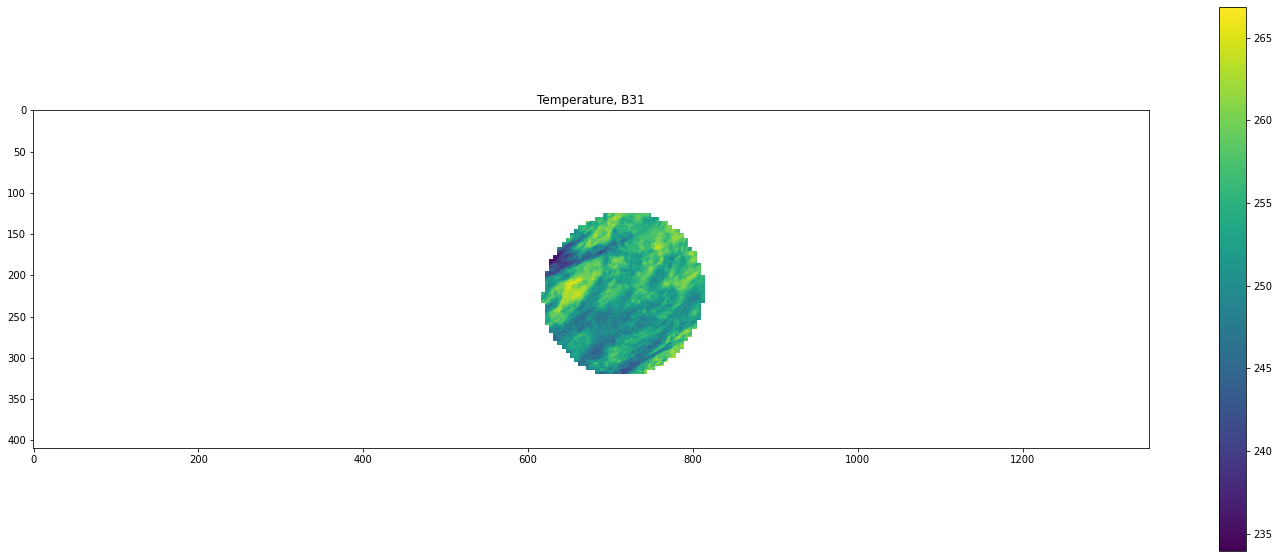

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
CS = ax.imshow(B31_roi)
cax = fig.colorbar(CS)
ax.set_title("Temperature, B31")
out = cax.ax.set_ylabel("")
out.set_verticalalignment("bottom")
out.set_rotation(270)

Подбор порога и преобразование в 0 и 1

In [0]:
p = 258 # зачем я поставил такой маленький порог по температуре?((
binary = np.where(B31_roi < p, 0, B31_roi)
binary = np.where(binary >= p, 1, binary)
binary = (binary - 1) * -1
binary = binary

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until


Окончательный бинарный растр

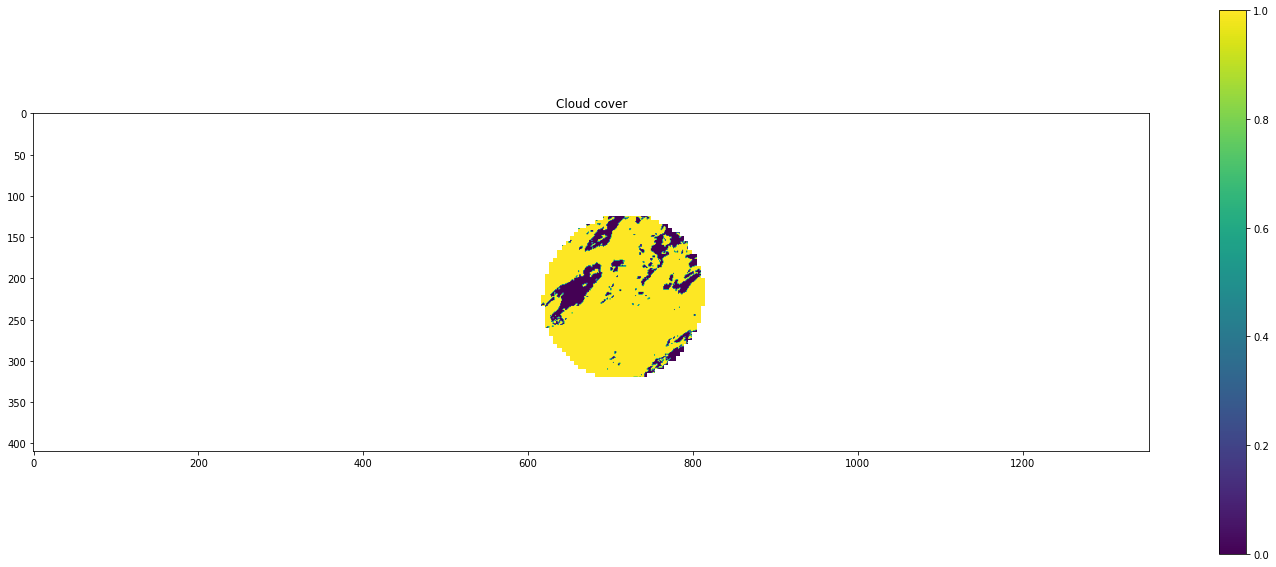

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
CS = ax.imshow(binary)
cax = fig.colorbar(CS)
ax.set_title("Cloud cover")
out = cax.ax.set_ylabel("")
out.set_verticalalignment("bottom")
out.set_rotation(270)
plt.savefig(cd + name)

In [0]:
uniq, counts = np.unique(binary, return_counts=True)
counts

array([ 5048, 25977,     1, ...,     1,     1,     1])

In [0]:
cloud_cover = (counts[1]) / sum(counts[:2])
print(f'Процент площади, покрытой облаками: {cloud_cover * 100:.2f}%')

Процент площади, покрытой облаками: 83.73%


Автоматическая отправка письма со всей информацией

In [0]:
import smtplib 
from email.mime.multipart import MIMEMultipart 
from email.mime.text import MIMEText 
from email.mime.base import MIMEBase 
from email import encoders 
   
fromaddr = 'baskinrobbinsman@gmail.com'
toaddr = 'onti-kosmosnimki@googlegroups.com'
msg = MIMEMultipart() 
msg['From'] = fromaddr 
msg['To'] = toaddr 
msg['Subject'] = 'Команда "Здесь могла быть ваша реклама", окончательная версия'
  
body = f'Здравствуйте!\nИмя исходного файла: {name + ".hdf"}\nПриёмная станция: {reciever} {coord_rec[reciever]}\nПроцент площади, покрытой облаками: {cloud_cover * 100:.2f}%\nМаска облачности: см. вложения\nС уважением, Евгений Иванкин'
msg.attach(MIMEText(body, 'plain')) 
filename =  name + '.png'
attachment = open(cd + filename, "rb") 
p = MIMEBase('application', 'octet-stream') 
p.set_payload((attachment).read()) 
encoders.encode_base64(p) 

p.add_header('Content-Disposition', "attachment; filename= %s" % filename) 
msg.attach(p) 
s = smtplib.SMTP('smtp.gmail.com', 587) 
s.starttls() 
s.login(fromaddr, 'пароль не дам))') 
text = msg.as_string() 
s.sendmail(fromaddr, toaddr, text) 
s.quit() 

(221, b'2.0.0 closing connection f68sm7698539pje.0 - gsmtp')

Экспорт в GeoTIFF с геопривязкой и без (не всегда работает)

In [0]:
from osgeo import osr

xmin,ymin,xmax,ymax = [lon.min(),lat.min(),lon.max(),lat.max()]
nrows, ncols = np.shape(binary)
xres = (xmax-xmin)/float(ncols)
yres = (ymax-ymin)/float(nrows)
geotransform=(xmin, xres, 0, ymax, 0, -yres)

output_raster = gdal.GetDriverByName('GTiff').Create(cd + name + '_CRS', ncols, nrows, 1, gdal.GDT_Float32)  # Open the file
output_raster.SetGeoTransform(geotransform)  # Specify its coordinates

srs = osr.SpatialReference()
srs.ImportFromProj4('+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs')
output_raster.SetProjection(srs.ExportToWkt())
b = output_raster.GetRasterBand(1)
b.SetNoDataValue(np.nan)
b.WriteArray(binary)
output_raster.FlushCache()

out2 = gdal.GetDriverByName('GTiff').Create(cd + name + '_NOCRS', ncols, nrows, 1, gdal.GDT_Float32)
b = out2.GetRasterBand(1)
b.SetNoDataValue(np.nan)
b.WriteArray(binary)
out2.FlushCache()